In [1]:
import numpy as np 
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import manifold
from scipy import sparse
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import euclidean_distances
import SemisupFns as SF
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import MiscFcns as MF
import seaborn as sns
import scipy.stats as ss
import mygene
from scipy.stats.stats import pearsonr
%matplotlib inline

In [41]:
def GetFeatureBR(df,br):
    ColNames = df.columns
    In = []
    for i in range(len(ColNames)):
        if br not in ColNames[i]:
            df = df.drop(ColNames[i], axis = 1)
            
    return df
    
        
    

In [122]:
#Reading feature vector 
X = pd.read_csv('./amp_ad_rna_seq_feature_set.csv')
GeneId = X.GeneID
X2 = GetFeatureBR(X,'DLPFC')
X2['GeneID'] = GeneId
X2.head()

,DLPFCdegree,DLPFCauthority_score,DLPFCcloseness,DLPFCeccentricity,DLPFCcentr_betw,DLPFCpagerank,DLPFC.AD-CONTROL.AOD.DOWN,DLPFC.AD-CONTROL.AOD.UP,DLPFC.AD-CONTROL.DOWN,DLPFC.AD-CONTROL.FEMALE.DOWN,...,aggregateDLPFCturquoiseDLPFCeccentricity,aggregateDLPFCturquoiseDLPFCcentr_betw,aggregateDLPFCturquoiseDLPFCpagerank,aggregateDLPFCyellowDLPFCdegree,aggregateDLPFCyellowDLPFCauthority_score,aggregateDLPFCyellowDLPFCcloseness,aggregateDLPFCyellowDLPFCeccentricity,aggregateDLPFCyellowDLPFCcentr_betw,aggregateDLPFCyellowDLPFCpagerank,GeneID
0,22,0.000579,3.127838e-08,9,22475.492836,0.000104,0,0,0,0,...,0,0.000000,0.000000,0,0.0,0.0,0,0.0,0.0,ENSG00000000003
1,8,0.000002,3.127567e-08,9,13576.287523,0.000055,0,0,0,0,...,0,0.000000,0.000000,0,0.0,0.0,0,0.0,0.0,ENSG00000000419
2,4,0.000003,3.126776e-08,9,2826.000108,0.000042,0,0,0,0,...,12,1080.414925,0.000415,0,0.0,0.0,0,0.0,0.0,ENSG00000000457
3,22,0.015326,3.127614e-08,9,12611.714094,0.000089,0,0,0,0,...,0,0.000000,0.000000,0,0.0,0.0,0,0.0,0.0,ENSG00000000938
4,27,0.022256,3.127683e-08,9,33233.304215,0.000110,0,0,0,0,...,0,0.000000,0.000000,0,0.0,0.0,0,0.0,0.0,ENSG00000000971


In [123]:
X2.to_csv('./amp_ad_rna_seq_feature_set_DLPFC.csv')

In [55]:
#read pheno file 
PhenoList = pd.read_csv('PWB_pheno.csv')
PhenoList.head()

,Unnamed: 0,refsnp_id,ensembl_gene_stable_id,distance_to_transcript,sift_score,clinical_significance,polyphen_score,phenotype_name,p_value,phenotype,external_gene_name
0,1,rs10067176,NaN,NaN,NaN,NaN,NaN,NaN,0.000007,SWB,NaN
1,2,rs10176315,ENSG00000178568,201154.0,NaN,NaN,NaN,NaN,0.000009,SWB1000G,ERBB4
2,3,rs10176315,ENSG00000178568,201150.0,NaN,NaN,NaN,NaN,0.000009,SWB1000G,ERBB4
3,4,rs10176315,ENSG00000178568,15109.0,NaN,NaN,NaN,NaN,0.000009,SWB1000G,ERBB4
4,5,rs10508258,NaN,NaN,NaN,NaN,NaN,NaN,0.000001,SWB1000G,NaN


In [59]:
set(PhenoList.phenotype)

{'LS', 'PA', 'SWB', 'SWB1000G'}

In [107]:
def GenY(GeneId, PhenoList, Pheno):
    UnqGenes = set(PhenoList.ensembl_gene_stable_id[PhenoList.phenotype == Pheno])
    
    Y = np.zeros(len(GeneId))
    
    print len(UnqGenes)
    for g in UnqGenes:
        In2 = np.where(GeneId == g)[0]
        
        if len(In2) >0: 
            Y[In2] = 1
            
        else:
            print g
    
    Y = pd.DataFrame(data = {'GeneID':GeneId, 'Y':Y})
    return Y
    

In [108]:
Y_LS = GenY(GeneId, PhenoList, 'LS')
Y_PA = GenY(GeneId, PhenoList, 'PA')
Y_SWB = GenY(GeneId, PhenoList, 'SWB')
Y_1000G = GenY(GeneId, PhenoList, 'SWB1000G')

15
nan
ENSG00000110975
LRG_7
ENSG00000249484
ENSG00000227757
ENSG00000149948
ENSG00000169126
ENSG00000249856
23
nan
ENSG00000254620
LRG_437
ENSG00000255314
ENSG00000228669
ENSG00000205628
ENSG00000231290
ENSG00000259221
LRG_535
34
nan
ENSG00000149948
LRG_437
ENSG00000082293
ENSG00000233334
ENSG00000227757
ENSG00000249484
ENSG00000203386
ENSG00000228669
ENSG00000282932
ENSG00000285382
ENSG00000273217
ENSG00000156269
ENSG00000258539
49
nan
ENSG00000269994
ENSG00000204393
ENSG00000232912
ENSG00000279765
ENSG00000233334
ENSG00000249307
ENSG00000154188
ENSG00000135114
ENSG00000257657
ENSG00000249484
ENSG00000205976
ENSG00000228669
ENSG00000183346
ENSG00000235910
ENSG00000156269
ENSG00000258539


In [110]:
Y_LS.to_excel('ResponseVec_LS.xlsx', index = False)
Y_PA.to_excel('ResponseVec_PA.xlsx', index = False)
Y_SWB.to_excel('ResponseVec_SWB.xlsx', index = False)
Y_1000G.to_excel('ResponseVec_SWB1000G.xlsx', index = False)

In [96]:
Y_LS['Y'].head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Y, dtype: float64

In [97]:
Y_LS['Y'].shape

(14448,)

In [141]:
bla = pd.read_csv('EC2_ConsUnion1_NoDeProbs_SWB1000G.csv')
bla.head()

,Unnamed: 0,Gene,Y0a,Y0b,Y1a,Y1b,Y2a,Y2b,Y3a,Y3b
0,0,ENSG00000000003,0.412213,0.412213,6.026506e-08,6.026506e-08,0.024068,0.024068,0.022629,0.022629
1,1,ENSG00000000419,0.412213,0.412213,3.367649e-06,3.367649e-06,0.063933,0.063933,0.042253,0.042253
2,2,ENSG00000000457,0.412213,0.412213,2.570307e-02,2.570307e-02,0.076924,0.076924,0.027319,0.027319
3,3,ENSG00000000938,0.412213,0.412213,5.412316e-04,5.412316e-04,0.008036,0.008036,0.015463,0.015463
4,4,ENSG00000000971,0.412213,0.412213,3.652335e-05,3.652335e-05,0.406587,0.406587,0.039447,0.039447


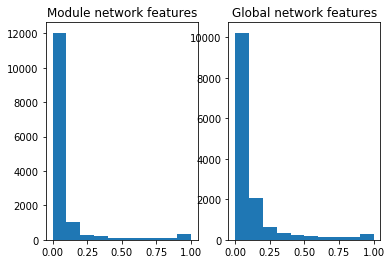

In [143]:
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.hist(bla.Y1a)
ax1.set_title('Module network features')
ax2.hist(bla.Y3a)
ax2.set_title('Global network features')
fig.savefig('SWB1000G_hist.jpg')

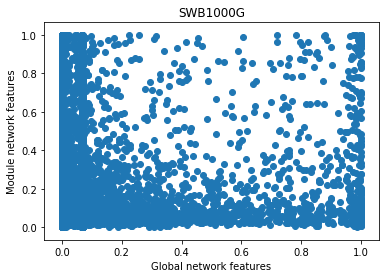

In [145]:
plt.scatter(bla.Y1a,bla.Y3a)
plt.xlabel('Global network features')
plt.ylabel('Module network features')
plt.title('SWB1000G')
plt.savefig('SWB1000G_compScore.jpg')

In [147]:
sum(bla.Y3a>.5)

910

In [156]:
def ConvertToSymb(GenePred):
    #GenePred - 1-d Python List
    mg = mygene.MyGeneInfo()
    temp = mg.querymany(GenePred , scopes='ensembl.gene', fields='symbol', species='human')
    GenePredSyms = []
    for i in range(len(GenePred)):
        if 'symbol' in temp[i]:
            GenePredSyms += [str(temp[i]['symbol'])]
        else:
            GenePredSyms += ['Not found']
        
        
    return GenePredSyms

In [190]:
#Identifying top predictions and ranking them 
In2 = np.argwhere((bla.Y1a>0.5) + (bla.Y3a>0.5))
ENSG_pred = bla.Gene[In2[:,0]]
Symb_pred = ConvertToSymb(ENSG_pred)


AttributeError: 'DataFrame' object has no attribute 'Y1a'

In [181]:
#In2 = In2[:,0]
OR1 = np.log10(np.array(bla.Y1a[In2])/(1-np.array(bla.Y1a[In2])))
OR3 = np.log10(np.array(bla.Y3a[In2])/(1-np.array(bla.Y3a[In2])))
OR_sum = OR1 + OR3

p_v = []
ph = []

for g in ENSG_pred:
    In = np.argwhere(PhenoList.ensembl_gene_stable_id == g)
    In = In[:,0]
    
    if len(In)>0:    
        p_v += [np.min(PhenoList.p_value[In])]
        s = ','
        ph += [s.join(set(PhenoList.phenotype[In]))]
    else:
        p_v += [1]
        ph += ['Not known']

data = {'GeneENSG':ENSG_pred,'GeneSymb':Symb_pred,'OR_mod':OR1,'OR_global':OR3,
       'OR_sum':OR_sum, 'Mean P-Value':p_v, 'Known Phenotypes':ph}
pred_df = pd.DataFrame(data = data)
pred_df.head()

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in divide
  


,GeneENSG,GeneSymb,Known Phenotypes,Mean P-Value,OR_global,OR_mod,OR_sum
9,ENSG00000001461,NIPAL3,Not known,1.0,-0.415525,6.675313,6.259787
27,ENSG00000003137,CYP26B1,Not known,1.0,0.769128,0.432456,1.201585
30,ENSG00000003393,ALS2,Not known,1.0,-0.836158,0.111229,-0.724929
44,ENSG00000004478,FKBP4,Not known,1.0,-1.387823,5.139445,3.751622
103,ENSG00000006128,TAC1,Not known,1.0,-1.615924,0.490522,-1.125402


In [182]:
pred_df.to_csv('SWB1000G_pred.csv')

In [187]:
bla = pd.read_csv('amp_ad_agg_feature_set_DLPFC.csv')
bla.shape

(14448, 50)

In [189]:
bla.head()

,Unnamed: 0,aggregateDLPFCblackDLPFCdegree,aggregateDLPFCblackDLPFCauthority_score,aggregateDLPFCblackDLPFCcloseness,aggregateDLPFCblackDLPFCeccentricity,aggregateDLPFCblackDLPFCcentr_betw,aggregateDLPFCblackDLPFCpagerank,aggregateDLPFCblueDLPFCdegree,aggregateDLPFCblueDLPFCauthority_score,aggregateDLPFCblueDLPFCcloseness,...,aggregateDLPFCturquoiseDLPFCeccentricity,aggregateDLPFCturquoiseDLPFCcentr_betw,aggregateDLPFCturquoiseDLPFCpagerank,aggregateDLPFCyellowDLPFCdegree,aggregateDLPFCyellowDLPFCauthority_score,aggregateDLPFCyellowDLPFCcloseness,aggregateDLPFCyellowDLPFCeccentricity,aggregateDLPFCyellowDLPFCcentr_betw,aggregateDLPFCyellowDLPFCpagerank,GeneID
0,0,0,0.000000,0.000000,0,0.000000,0.000000,21,0.150882,0.000006,...,0,0.000000,0.000000,0,0.0,0.0,0,0.0,0.0,ENSG00000000003
1,1,2,0.014469,0.000002,9,81.217486,0.000215,0,0.000000,0.000000,...,0,0.000000,0.000000,0,0.0,0.0,0,0.0,0.0,ENSG00000000419
2,2,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,...,12,1080.414925,0.000415,0,0.0,0.0,0,0.0,0.0,ENSG00000000457
3,3,0,0.000000,0.000000,0,0.000000,0.000000,12,0.012451,0.000006,...,0,0.000000,0.000000,0,0.0,0.0,0,0.0,0.0,ENSG00000000938
4,4,0,0.000000,0.000000,0,0.000000,0.000000,12,0.009634,0.000006,...,0,0.000000,0.000000,0,0.0,0.0,0,0.0,0.0,ENSG00000000971
